In [0]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip "/content/gdrive/My Drive/Image.zip"

In [0]:
class DataGen(keras.utils.Sequence):
  def __init__(self, ids, path, batch_size, image_size):
    self.ids= ids
    self.path = path 
    self.batch_size= batch_size 
    self.image_size= image_size
    self.on_epoch_end()
   
  def __load__(self,id_name):
    #definging image and mask path structure
    image_path = os.path.join(self.path, id_name, 'images', id_name) + ".png"
    mask_path = os.path.join(self.path, id_name, "masks/")
    all_masks = os.listdir(mask_path)
    
    #reading images
    image = cv2.imread(image_path,1)
    image = cv2.resize(image,(self.image_size, self.image_size)) #resize
    
    #reading Masks
    mask = np.zeros((self.image_size, self.image_size,1)) #baseline
    
    for name in all_masks:
      _mask_path = mask_path + name
      _mask_image = cv2.imread(_mask_path,-1)
      _mask_image = cv2.resize(_mask_image, (self.image_size,self.image_size)) #resize
      _mask_image = np.expand_dims(_mask_image,axis= -1)
      mask = np.maximum(mask, _mask_image) 
      
    #normalizing 
    image = image/255.0
    mask = mask/255.0
    
    return image, mask 
  
  def __getitem__(self, index):
    if (index+1)*self.batch_size > len(self.ids):
      self.batch_size = len(self.ids)- (index*self.batch_size)

    files_batch = self.ids[(index)*self.batch_size:(index+1)*self.batch_size]
    
    image=[]
    mask=[]
    
    for id_name in files_batch:
      _image , _mask = self.__load__(id_name)
      image.append(_image)
      mask.append(_mask)
      
    image = np.array(image)
    mask = np.array(mask)
    
    return image, mask 
  
  def on_epoch_end(self):
    pass
  
  def __len__(self):
    return int(np.ceil(len(self.ids)/float(self.batch_size)))

### Hyperparameters 

In [0]:
image_size= 128
batch_size=5
epochs=5
train_path = "/content/Image/images"

data_ids = next(os.walk(train_path))[1]

valid_size = 10

vaidation_ids = data_ids[:valid_size]
train_set_ids = data_ids[valid_size:]



#### Get data

In [91]:
gen = DataGen(train_set_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(5, 128, 128, 3) (5, 128, 128, 1)


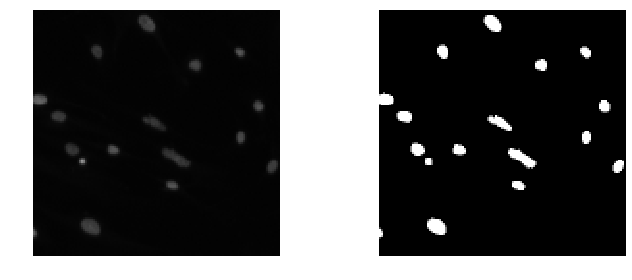

In [92]:
plt.figure(figsize=(10,4))

r = random.randint(0, len(x)-1)

plt.subplot(1,2,1)
plt.imshow(x[r])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.reshape(y[r],(image_size,image_size)),cmap= 'gray')
plt.axis('off')


plt.tight_layout()
plt.show()

#### U-NET

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [0]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [0]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
#model.summary()

In [94]:
train_gen = DataGen(train_set_ids, 
                    train_path, 
                    image_size=image_size, 
                    batch_size=batch_size)
valid_gen = DataGen(vaidations_ids, 
                    train_path, 
                    image_size=image_size, 
                    batch_size=batch_size)

train_steps = len(train_set_ids)//batch_size
valid_steps = len(vaidations_ids)//batch_size

model.fit_generator(train_gen, 
                    validation_data=valid_gen, 
                    steps_per_epoch=train_steps, 
                    validation_steps=valid_steps,
                    epochs=5)

Epoch 1/5
44/44 [==============================] - 12s 279ms/step - loss: 2.8191 - acc: 0.8241 - val_loss: 2.5701 - val_acc: 0.7712
Epoch 2/5
44/44 [==============================] - 10s 220ms/step - loss: 1.7871 - acc: 0.8457 - val_loss: 1.8381 - val_acc: 0.7712
Epoch 3/5
44/44 [==============================] - 10s 224ms/step - loss: 1.3395 - acc: 0.8507 - val_loss: 1.4338 - val_acc: 0.7897
Epoch 4/5
44/44 [==============================] - 10s 219ms/step - loss: 1.0319 - acc: 0.8881 - val_loss: 1.1719 - val_acc: 0.8813
Epoch 5/5
44/44 [==============================] - 10s 227ms/step - loss: 0.8403 - acc: 0.9190 - val_loss: 0.8869 - val_acc: 0.9008


In [0]:
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5


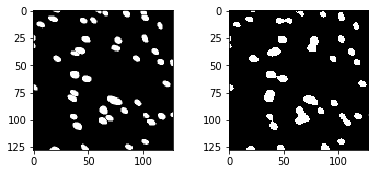

In [96]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

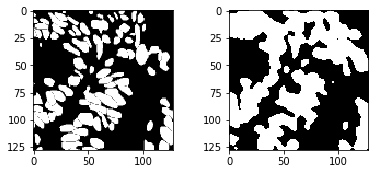

In [97]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")